In this notebook,
we try to get two cliffs in a single data scaling plot with linear regression.

## THIS RESULTED IN A FAILURE!!
The reason is that the cliff for linear regression
is not determined purely by the D.O.F. of the learner.

### Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import dataclasses
import logging
import os
import sys
import warnings
from typing import Callable

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
from tqdm.auto import tqdm

logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"


In [3]:
sys.path.append("../..")

from src import utils
from src.experiments.harmonics.data import (
    HypercubeDataModule,
    HypercubeDataModuleConfig,
)
from src.experiments.harmonics.harmonics import HarmonicFn, HarmonicFnConfig

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)


### Utility code

In [4]:
def get_mse(
    model: pl.LightningModule,
    dl: torch.utils.data.DataLoader,
) -> torch.Tensor:
    return pl.Trainer(enable_progress_bar=False).test(
        model=model,
        dataloaders=dl,
        verbose=False,
    )[0]["test_mse"]


@dataclasses.dataclass(frozen=True)
class LSData:
    ns: np.ndarray
    val_mses: np.ndarray


def run_lstsq_exp(
    ns: list[int],
    true_fn: Callable[[torch.Tensor], torch.Tensor],
    estimator: Callable[[np.ndarray, np.ndarray], pl.LightningModule],
    input_dim: int,
    noise_std: float = 0.0,
    n_val: int = 1024,
) -> np.ndarray:
    val_mses = []
    for n_train in tqdm(ns):
        dm = HypercubeDataModule(
            fn=true_fn,
            cfg=HypercubeDataModuleConfig(
                input_dim=input_dim,
                n_train=n_train,
                n_val=n_val,
                train_seed=n_train,
                val_seed=-1,
                num_workers=0,
                batch_size=256,
            ),
        )
        dm.setup()

        xs_train = dm.train_ds.tensors[0].numpy()
        ys_train = dm.train_ds.tensors[1].numpy()

        fn_hat = estimator(
            xs_train,
            ys_train + noise_std * np.random.normal(size=len(ys_train)),
        )

        mse = get_mse(model=fn_hat, dl=dm.val_dataloader())
        val_mses.append(mse)

    return LSData(
        ns=np.array(ns),
        val_mses=np.array(val_mses),
    )

### Groundtruth functions

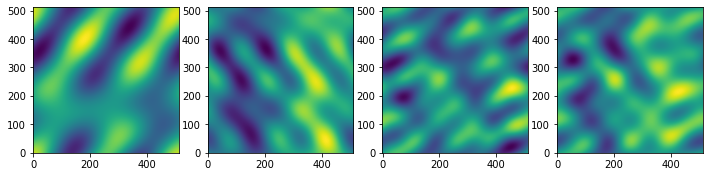

In [5]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 4, 1)
FN_H2 = HarmonicFn(
    HarmonicFnConfig(
        input_dim=2,
        freq_limit=2,
        num_components=3,
        dtype=torch.float64,
    )
)
utils.viz_2d_hd(pred_fn=FN_H2, side_samples=512, pad=(0, 0));

plt.subplot(1, 4, 2)
FN_H3 = HarmonicFn(
    HarmonicFnConfig(
        input_dim=2,
        freq_limit=3,
        num_components=12,
        dtype=torch.float64,
    )
)
utils.viz_2d_hd(pred_fn=FN_H3, side_samples=512, pad=(0, 0));

plt.subplot(1, 4, 3)
FN_H4 = HarmonicFn(
    HarmonicFnConfig(
        input_dim=2,
        freq_limit=4,
        num_components=40,
        dtype=torch.float64,
    )
)
utils.viz_2d_hd(pred_fn=FN_H4, side_samples=512, pad=(0, 0));

plt.subplot(1, 4, 4)
FN_HSUM = lambda x: FN_H3(x) + FN_H4(x)
utils.viz_2d_hd(pred_fn=FN_HSUM, side_samples=512, pad=(0, 0));

### Manual run

Train MSE: 7.35378934395986e-13
Test MSE: 0.44616517424583435


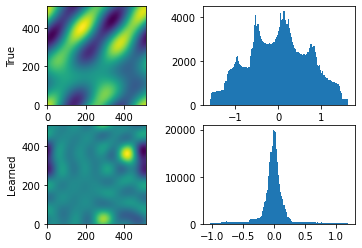

In [6]:
TRUE_FN = FN_H2
#TRUE_FN = FN_H3
#TRUE_FN = FN_H4
#TRUE_FN = FN_HSUM

dm = HypercubeDataModule(
    fn=TRUE_FN,
    cfg=HypercubeDataModuleConfig(
        input_dim=2,
        n_train=10,
        n_val=10_000,
        train_seed=-1,
        val_seed=100,
        num_workers=0,
        batch_size=256,
    ),
)
dm.setup()

xs_train: np.ndarray = dm.train_ds.tensors[0].numpy().astype(np.float64)
ys_train: np.ndarray = dm.train_ds.tensors[1].numpy().astype(np.float64)

fn_hat = HarmonicFn.construct_via_lstsq(
    xs=xs_train,
    ys=ys_train,
    freq_limit=4,
    dtype=torch.float64,
)

print("Train MSE:", get_mse(model=fn_hat, dl=dm.train_dataloader(shuffle=False)))
print("Test MSE:", get_mse(model=fn_hat, dl=dm.val_dataloader()))

plt.subplot(2, 2, 1)
img = utils.viz_2d_hd(pred_fn=TRUE_FN, side_samples=512, pad=(0, 0));
plt.ylabel("True");
plt.subplot(2, 2, 2)
plt.hist(img.flatten(), bins=128)

plt.subplot(2, 2, 3)
img = utils.viz_2d_hd(pred_fn=fn_hat, side_samples=512, pad=(0, 0));
plt.ylabel("Learned");
plt.subplot(2, 2, 4)
plt.hist(img.flatten(), bins=128);

### Scaling experiments

In [7]:
DATA = dict()

In [8]:
for tag, fn in [("h3", FN_H3), ("h4", FN_H4), ("hsum", FN_HSUM)]:
    DATA[tag] = run_lstsq_exp(
        ns=list(range(1, 100, 10)) + [200, 400, 800],
        true_fn=fn,
        estimator=lambda xs, ys: HarmonicFn.construct_via_lstsq(
            xs=xs,
            ys=ys,
            freq_limit=4,
        ),
        input_dim=2,
    )

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

In [9]:
for freq_limit in [3, 4, 5]:
    DATA[f"dof{freq_limit}"] = HarmonicFn.harmonic_basis(torch.tensor([[1,2]]), freq_limit=freq_limit)[0].shape[-1]
    print(freq_limit, DATA[f"dof{freq_limit}"])

3 49
4 81
5 121


### Plots

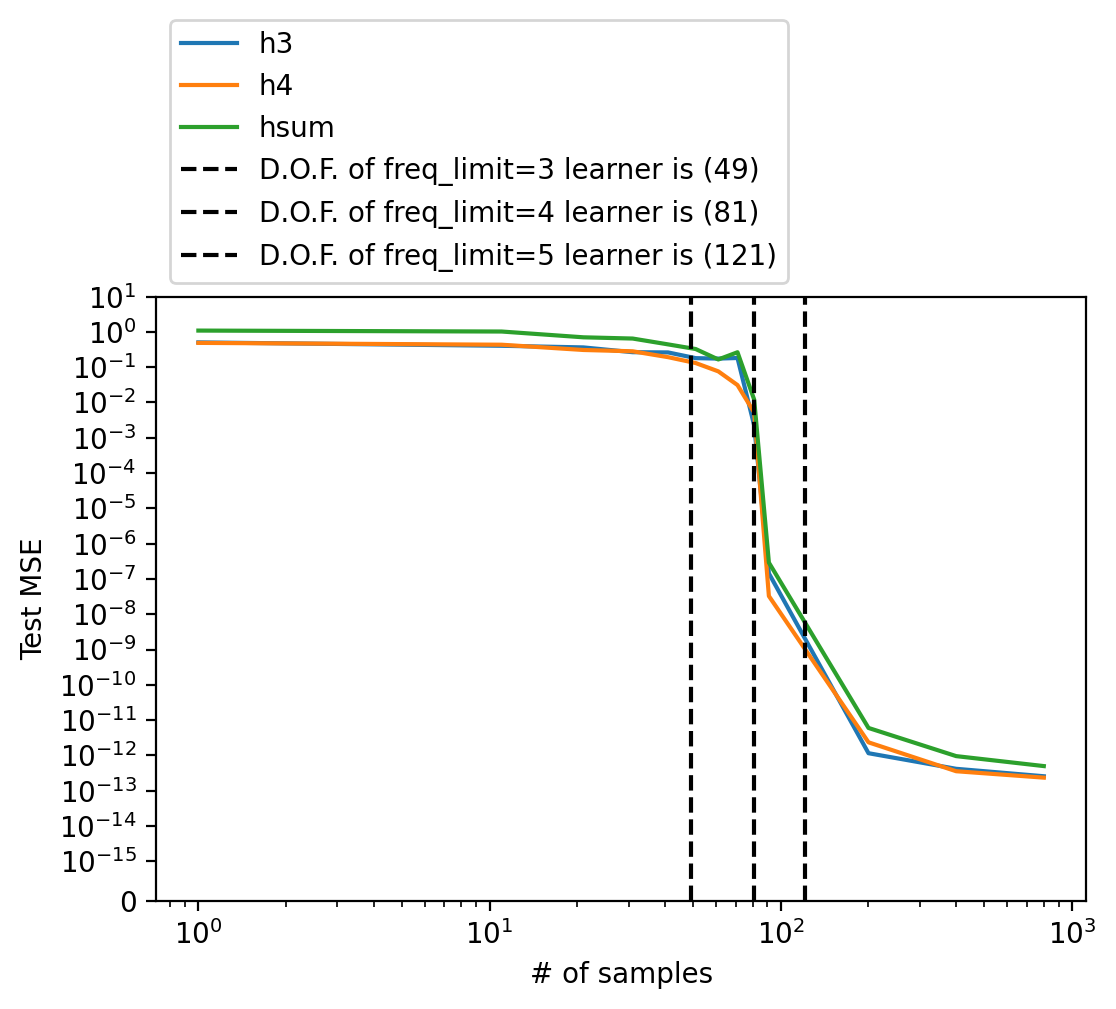

In [10]:
plt.figure(dpi=200)

for tag in ["h3", "h4", "hsum"]:
    plt.plot(DATA[tag].ns, DATA[tag].val_mses, label=tag)
# plt.axhline(
#     DATA["hsum3lim"],
#     color="black",
#     linestyle="--",
#     label="Analytic hsum3 limit = 1e-4 * (1 / 6 - 49 / (36 pi^2))"
# )
for freq_limit in [3, 4, 5]:
    plt.axvline(
        DATA[f"dof{freq_limit}"],
        color="black",
        linestyle="--",
        label=f"D.O.F. of {freq_limit=} learner is ({DATA[f'dof{freq_limit}']})",
    )

plt.xscale("log")
plt.yscale("symlog", linthresh=1e-15)
plt.ylim(0, 10)
plt.legend(loc="lower left", bbox_to_anchor=(0, 1))
plt.xlabel("# of samples")
plt.ylabel("Test MSE");